In [1]:
import sys
sys.path.append("./pipeline")
import os

import numpy as np
import torch
import subprocess
from PIL import Image
import cv2

import pytorch_kinematics as pk
from pointcloud import PointCloud
from optimizer import Optimizer
from ebm_trainer import EBMTrainer, PlanarEBMTrainer, SurfaceClassifier, PlanarClassifier, PointDataset, PlanarDataset
from utils import read_yaml, draw_points_2D, draw_trajectory, draw_pointcloud, find_bounding_box
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from benchmarking.visual_utils import generate_scatter_3d, generate_energies_heatmap
from benchmarking.visualizer import Visualizer
from pipeline.general import Pose

pybullet build time: Nov 28 2023 23:51:11


# Set Workspace, Config, and URDF

In [2]:
config_path = "./pipeline/config.yaml"
config = read_yaml(config_path)
working_directory = "./pipeline/saves/tables_a"

urdf = open("./urdf/z1_description/xacro/z1.urdf").read()
chain = pk.build_serial_chain_from_urdf(urdf, end_link_name='gripper').to(device='cuda')

# Another option
# urdf = open("./urdf/franka_mobile_panda/mobile_panda_with_gripper.urdf").read()
# chain = pk.build_serial_chain_from_urdf(urdf, end_link_name='panda_grasptarget').to(device='cuda')

## Annotate & Save ROI/Constraint (optional)

loading images from: ./pipeline/saves/mixed/COLOR_1600x1200.png
Detection object:
tag_family = b'tag36h11'
tag_id = 0
hamming = 0
decision_margin = 90.91812133789062
homography = [[ 1.82694590e+01 -2.46602536e+01  6.61822862e+02]
 [-7.90893541e-01 -2.93548568e+00  8.96267748e+02]
 [-6.81625614e-03 -2.13411714e-02  1.00000000e+00]]
center = [661.82286236 896.26774846]
corners = [[628.01501465 907.30163574]
 [674.42205811 918.40118408]
 [694.66265869 885.54980469]
 [649.91375732 875.34661865]]
pose_R = [[ 0.94255676 -0.33344653  0.02000407]
 [ 0.1433537   0.45785577  0.87739262]
 [-0.3017225  -0.82412469  0.47935585]]
pose_t = [[-0.17986104]
 [ 0.38375187]
 [ 1.69114447]]
pose_err = 6.976599756259561e-09



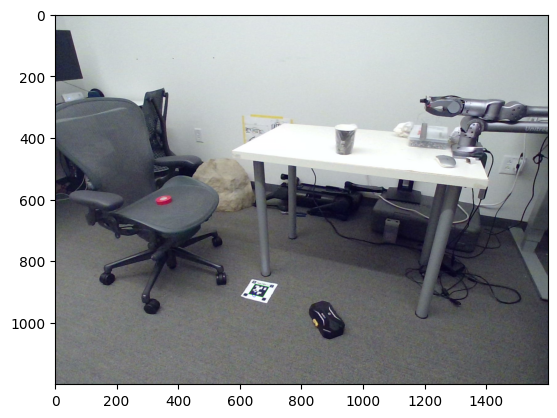

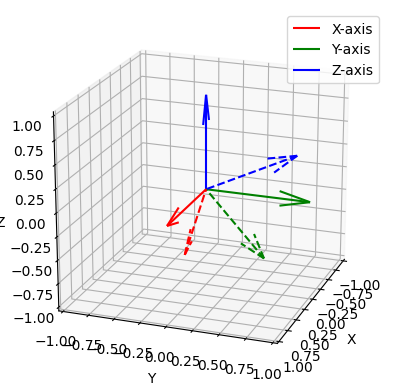

In [ ]:

pc = PointCloud(images_path=working_directory, high_res_depth=False, config=config) 

pose = Pose(np.array([
    [0, -1, 0],
    [-1, 0, 0],
    [0, 0, -1]
]), np.array([
    [0], [-1], [0]
]))

pc.find_camera_pose(visualize=True)
region, region_constraint = pc.annotate()
pc.save_pointcloud_pixels(region)
pc.save_constraint_pixels(region_constraint)

points_in_world = pc.compute_points_in_world(region, tag_to_world=pose, visualize=True)
print("Points in world frame:", points_in_world)

points_constraint = pc.compute_points_in_world(region_constraint, tag_to_world=pose, visualize=True)
print("Points in constraint:", points_constraint)

pc.save_pointcloud(points_in_world)
pc.save_constraint(points_constraint)

## Train & Save Model (optional)

In [ ]:
# EBM for ROI
roi_trainer = EBMTrainer(working_directory, config)
print("training ROI classfier...")
roi_trainer.train()
roi_trainer.save_classifier()

# EBM for Constraint
if os.path.exists(os.path.join(working_directory, config['io']['constraint_name'])):
    constraint_trainer = PlanarEBMTrainer(working_directory, config)
    print("training constraint classfier...")
    constraint_trainer.train()
    constraint_trainer.save_classifier()

## Optimize

In [3]:
opt = Optimizer(working_directory, config, chain, constraints=True)
bases, energies = opt.optimize(ic=None)

tensor([-2.6180,  0.0000, -2.8798, -1.5184, -1.3439, -2.7925], device='cuda:0') tensor([2.6180, 2.9671, 0.0000, 1.5184, 1.3439, 2.7925], device='cuda:0')
tensor([-0.1378, -0.7119,  0.4200,  0.0387], device='cuda:0')
tensor([-0.1457, -0.7188,  0.4200,  0.0870], device='cuda:0')
tensor([-0.1469, -0.7198,  0.4200,  0.1341], device='cuda:0')
tensor([-0.1483, -0.7210,  0.4200,  0.1825], device='cuda:0')


## Gradient ascent trajectory in 2D

result: tensor([-0.1483, -0.7210,  0.4200,  0.1825], device='cuda:0')


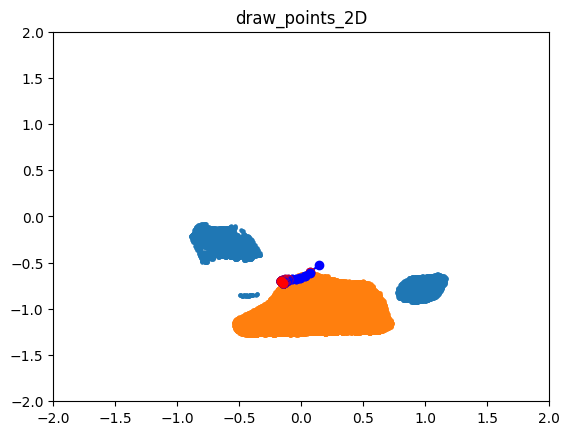

In [4]:
fig, ax = plt.subplots(1, 1)
draw_points_2D(ax, opt.roi_points, limits=torch.tensor([[-2.0, -2], [2.0, 2.0]]), cube=True)
draw_points_2D(ax, opt.constraint_points, limits=torch.tensor([[-2.0, -2], [2.0, 2.0]]), cube=True)
draw_trajectory(ax, bases, energies)
print("result:", bases[-1][1])
plt.show()

## Visualize scenes Tables A, Tables B, Drawer, Mixed

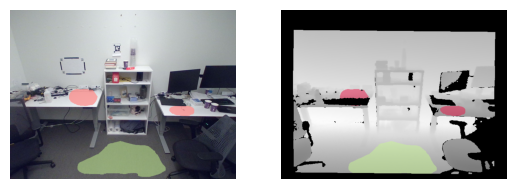

In [6]:
vis = Visualizer("./pipeline/saves/tables_a", config, high_res_depth=False, constraint=True)
vis.visualize()

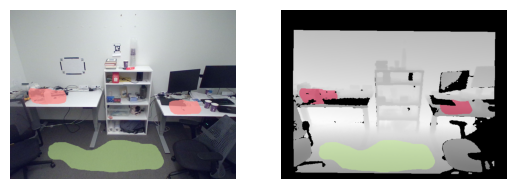

In [7]:
vis = Visualizer("./pipeline/saves/tables_b", config, high_res_depth=False, constraint=True)
vis.visualize()

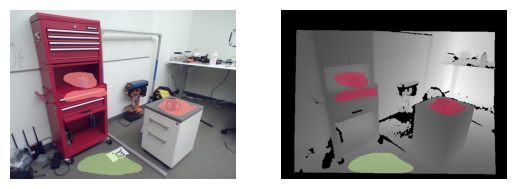

In [8]:
vis = Visualizer("./pipeline/saves/drawer", config, high_res_depth=False, constraint=True)
vis.visualize()

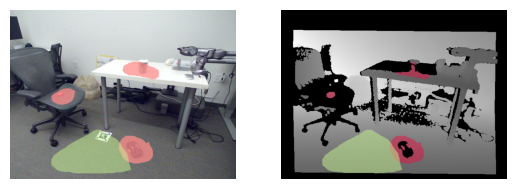

In [9]:
vis = Visualizer("./pipeline/saves/mixed", config, high_res_depth=False, constraint=True)
vis.visualize()

## Visualize pointcloud and optimization trajectory

In [4]:
def rgb_to_string(pixel):
    return f"rgb({pixel[0]},{pixel[1]},{pixel[2]})"

def colorize(points, pixels, transform):
    return go.Scatter3d(
        x=points[0], 
        y=points[1], 
        z=points[2], 
        mode='markers', 
        marker=dict(
            size=1,
            color=list(rgb_to_string(transform(pixel)) for pixel in pixels)
        )
    )

def visualize_optimization(traces, opt, bases_list, energies_list):

    trajectories = [
        go.Scatter3d(
            x=[i[1].cpu().numpy()[0] for i in bases], 
            y=[i[1].cpu().numpy()[1] for i in bases], 
            z=[i[1].cpu().numpy()[2] for i in bases], 
            marker=dict(
                size=4,
                color=[float(i.cpu().numpy()) for i in energies],
                colorscale='Viridis',
                colorbar=dict(
                    title="Expected log likelihood"
                ),
                cmax=-30,
                cmin=-100
            ),
            line={
                'color': 'darkblue',
                'dash': 'solid'
            }
        ) 
        for (bases, energies) in zip(bases_list, energies_list)
    ]

    heapmap = generate_energies_heatmap(opt.sigmoidless_classifier, limits=np.array([[-1.2, -1.2, 0], [1.2, 0, 1.2]]), lo=-20, hi=6)
    plots = traces + [heapmap] + trajectories
    
    fig = go.Figure(data=plots)
    fig.update_layout(
        scene=dict(
            aspectmode="data"
        ),
        height=800
    )
    fig.show()

In [ ]:
pc = PointCloud(images_path="./pipeline/saves/tables_a", high_res_depth=False, config=config) 
pc.find_camera_pose()
mask_all = np.ones((480, 640))

roi_mask = pc.get_roi_mask()
constraint_mask = pc.get_constraint_mask()
spectator_mask = np.logical_and(np.logical_and(mask_all, np.logical_not(roi_mask)), np.logical_not(constraint_mask)).astype(np.uint8)

spectator_points, spectator_pixels = pc.compute_points_in_world(spectator_mask, pixels=True)
roi_points, roi_pixels = pc.compute_points_in_world(roi_mask, pixels=True)
constraint_points, constraint_pixels = pc.compute_points_in_world(constraint_mask, pixels=True)

visualize_optimization([
    colorize(spectator_points, spectator_pixels, lambda x: x),
    colorize(roi_points, roi_pixels, lambda x: (255, 0, 0)),
    colorize(constraint_points, constraint_pixels, lambda x: (0, 255, 0))
], opt, [bases], [energies])